In [18]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
from random import choice, randint
from pathlib import Path

import importlib
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pickle

import ptwt, pywt

from sphfile import SPHFile
import librosa
import librosa.display
import soundfile

import dataset
from dataset import pickle_stft_data, pickle_stft_data_snr

In [19]:
importlib.reload(dataset)

<module 'dataset' from '/home/pakumar/teams/ece251c-team-11/notebooks/dataset.py'>

In [20]:
# define device type - cuda:0 or cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
kwargs = {'num_workers': 4, 'pin_memory': False} if device.type == "cuda" else {}

# Additional Info when using cuda
if device.type == 'cuda':
    print("Number of GPU devices:", torch.cuda.device_count())
    print("GPU device name:", torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3, 3), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3, 3), 'GB')

Number of GPU devices: 1
GPU device name: GeForce GTX 1070 Ti
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [37]:
TRAIN_BATCH_SIZE = 8
TEST_BATCH_SIZE = 1

BASE_DIR = Path(os.getcwd()).parent
DATA_DIR = BASE_DIR / 'data'

## Dataset

In [39]:
def plot_spectrogram(stft, title="Spectrogtam"):
    fig, ax = plt.subplots()
    img = librosa.display.specshow(librosa.amplitude_to_db(np.abs(stft), ref=np.max), y_axis='log', x_axis='time', ax=ax)
    ax.set_title(title)
    fig.colorbar(img, ax=ax, format="%+2.0f dB")

## Function to load pickle data

In [40]:
def plot_signal_stats(signal_len_lst):
    fig = plt.figure(figsize=(16,6))
    plt.subplot(1,2,1)
    plt.plot(signal_len_lst, linestyle='', marker='.')
    plt.xlabel("file idx")
    plt.ylabel("signal length")
    plt.grid(linestyle='--')

    plt.subplot(1,2,2)
    counts, bins = np.histogram(signal_len_lst)
    plt.hist(bins[:-1], bins, weights=counts)
    plt.xlabel("signal length")
    plt.ylabel("#signals")
    plt.grid(linestyle='--')

In [41]:
def load_pkl_data(split, num_samples):
    pkl_file = DATA_DIR / 'pkl_files' / '{}_data'.format(split) / 'clean_mixed_data_snr_{}.pickle'.format(num_samples)
    print(pkl_file)
    if not pkl_file.is_file():
        print('Generating data ...')
        signal_len_lst = pickle_stft_data_snr(split, num_samples=num_samples)
        plot_signal_stats(signal_len_lst)
        
    with open(pkl_file, 'rb') as handle:
        clean_mixed_data_dict = pickle.load(handle)
    
    return clean_mixed_data_dict

In [42]:
class SpeechDataset(Dataset):
    def __init__(self, split='train', num_samples=1000, alpha=0.8):
        assert split in ['train', 'val', 'test'], "Invalid split"
        self.split = split
        self.alpha = alpha
        self.num_samples = num_samples
        self.clean_mixed_data_dict = load_pkl_data(split, num_samples)
    
    def __len__(self):
        return self.num_samples
#         return len(self.file_list)
    
    def __getitem__(self, idx):
        stft_clean = self.clean_mixed_data_dict['clean'][idx]
        stft_mixed = self.clean_mixed_data_dict['mixed'][idx]
        
        return stft_clean, stft_mixed

### Dataset stats

In [43]:
def dataset_stats(dataloader):
    num_batches = len(dataloader)
    len_list = []
    for itr in range(num_batches):
        clean_spec, noisy_spec = next(iter(dataloader))
        len_list.append(clean_spec[0].size()[0])
    print(clean_spec[0].size())
    counts, bins = np.histogram(len_list)
    plt.hist(bins[:-1], bins, weights=counts)
    plt.xlabel("signal length")
    plt.ylabel("#signals")
    plt.grid(linestyle='--')
    plt.show()

### Load training data

/home/pakumar/teams/ece251c-team-11/data/pkl_files/train_data/clean_mixed_data_snr_2000.pickle
Train dataset size: 250
torch.Size([257, 18])


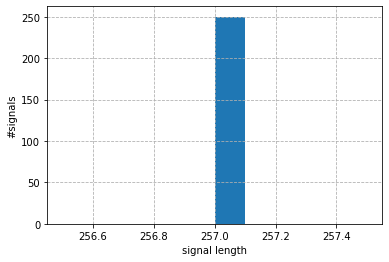

In [44]:
train_dataset = SpeechDataset('train', num_samples=2000)
train_dataloader = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE, collate_fn=dataset.custom_collate_fn)
print("Train dataset size:", len(train_dataloader))
dataset_stats(train_dataloader)

### Load test data

In [45]:
test_dataset = SpeechDataset('test', num_samples=500)
test_dataloader = DataLoader(test_dataset, batch_size=TEST_BATCH_SIZE, collate_fn=dataset.custom_collate_fn)
print("Test dataset size:", len(test_dataloader))
dataset_stats(test_dataloader)

/home/pakumar/teams/ece251c-team-11/data/pkl_files/test_data/clean_mixed_data_snr_500.pickle
Generating data ...


  0%|          | 0/500 [00:00<?, ?it/s]

KeyboardInterrupt: 

### Define Model

In [46]:
class Padding():
    @staticmethod
    def pad(x, stride):
        h, w = x.shape[-2:]

        if h % stride > 0:
            new_h = h + stride - h % stride
        else:
            new_h = h
        if w % stride > 0:
            new_w = w + stride - w % stride
        else:
            new_w = w
        lh, uh = int((new_h-h) / 2), int(new_h-h) - int((new_h-h) / 2)
        lw, uw = int((new_w-w) / 2), int(new_w-w) - int((new_w-w) / 2)
        pads = (lw, uw, lh, uh)

        # zero-padding by default.
        # See others at https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.pad
        out = F.pad(x, pads, "reflect")

        return out, pads
    
    @staticmethod
    def unpad(x, pad):
        if pad[2]+pad[3] > 0:
            x = x[:,:,pad[2]:-pad[3],:]
        if pad[0]+pad[1] > 0:
            x = x[:,:,:,pad[0]:-pad[1]]
        return x

In [47]:
class WaveletPooling(nn.Module):
    def __init__(self, wavelet):
        super(WaveletPooling,self).__init__()
        self.upsample_ = nn.Upsample(scale_factor=2, mode='nearest')
        self.wavelet = wavelet
    
    def forward(self, x):
        bs = x.size()[0]
        FORWARD_OUTPUT_ = []
        
        # loop over input as batching not supported
        for k in range(bs):
            # coeffiecients - cx1xhxw
            coefficients = ptwt.wavedec2(x[k,:,:,:], pywt.Wavelet(self.wavelet),
                                        level=2, mode="constant")
            # 2nd order DWT
            forward_output_ = ptwt.waverec2([coefficients[0], coefficients[1]], pywt.Wavelet(self.wavelet))
            
            # permute dim - 1xcxhxw
            FORWARD_OUTPUT_.append(torch.permute(forward_output_, [1,0,2,3]))
        
        FORWARD_OUTPUT_ = torch.cat(FORWARD_OUTPUT_, dim = 0)
        
        if x.shape[-1]/2 != FORWARD_OUTPUT_.shape[-1]:
            FORWARD_OUTPUT_ = FORWARD_OUTPUT_[:,:,:,:]
        if x.shape[-2]/2 != FORWARD_OUTPUT_.shape[-2]:
            FORWARD_OUTPUT_ = FORWARD_OUTPUT_[:,:,:-1,:]
        
        return FORWARD_OUTPUT_

In [48]:
def wavelet_pooling_hook(module, inp, out):
    '''
    inp - gradient output from the layer
    out - gradient inp to layer 
    '''    
    # Computing gradient using paper.
    bs = out[0].size()[0]
    BACKWARD_OUTPUT_ = []

    # loop over input as batching not supported
    for k in range(bs):
        ## 1. 1st order DWT
        coefficients = ptwt.wavedec2(torch.squeeze(out[0][k]), pywt.Wavelet("haar"),
                                        level=1)#, mode="constant")
        ## 2. upsample subbands
        # LL
        upsampled_subbands_ = coefficients
        
        # LH, HL, HH
        upsampled_subbands_.append([])
        for k in range(len(coefficients[1])):
            upsampled_subbands_[-1].append(module.upsample_(coefficients[1][k]))
        upsampled_subbands_[-1] = tuple(upsampled_subbands_[-1])  

        ## 3. IDWT
        backward_output_ = ptwt.waverec2(upsampled_subbands_, pywt.Wavelet("haar"))
        BACKWARD_OUTPUT_.append(backward_output_.permute(1,0,2,3))
    
    BACKWARD_OUTPUT_ = torch.cat(BACKWARD_OUTPUT_, dim = 0)
    
    cw = 4-inp[0].shape[2]%4
    ch = 4-inp[0].shape[3]%4
    
    if cw != 4:
        BACKWARD_OUTPUT_ = BACKWARD_OUTPUT_[:,:,:-cw,:]
    
    if ch != 4:
        BACKWARD_OUTPUT_ = BACKWARD_OUTPUT_[:,:,:,:-ch]
        
    BACKWARD_OUTPUT_SHAPE_ = BACKWARD_OUTPUT_.shape
    
    return [BACKWARD_OUTPUT_]

In [49]:
class Pooling(nn.Module):
    def __init__(self, params):
        super().__init__()
        if params['pooling'] == 'wavelet':
            print('Waveler pooling ....')
            self.pool = WaveletPooling(params['wavelet'])
        else:
            print('Max pooling ....')
            self.pool = nn.MaxPool2d(3,2,1)
    
    def forward(self, x):
        return self.pool(x)

In [50]:
class CausalConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, params):
        super().__init__()
        self.conv_layer = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=(3, 3),            
            padding=(1, 1)
        )
        self.pool = Pooling(params)
        self.norm = nn.BatchNorm2d(num_features=out_channels)
        self.activation = nn.ReLU()

    def forward(self, x):
        """
        2D Causal convolution.
        Args:
            x: [batch_size, num_channels, F, T]
        Returns:
            [B, C, F, T]
        """
        x = self.conv_layer(x)
        x = self.pool(x)
        x = self.norm(x)
        x = self.activation(x)
        
        return x

In [51]:
class CausalTransConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, is_last=False):
        super().__init__()
        
        self.conv = nn.ConvTranspose2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=(3, 3),
            stride=(2, 2),
            padding = (1,1),
            output_padding = (1,1)
        )
        
        
        self.norm = nn.BatchNorm2d(num_features=out_channels)
        if is_last:
            self.activation = nn.ReLU()
        else:
            self.activation = nn.ELU()

    def forward(self, x):
        """
        2D Causal convolution.
        Args:
            x: [B, C, F, T]
        Returns:
            [B, C, F, T]
        """
        x = self.conv(x)
        x = self.norm(x)
        x = self.activation(x)
        
        return x

In [52]:
class ConvRecNet(nn.Module):
    """
    Input: [batch size, channels=1, T, n_fft]
    Output:[batch size, channels=1, T, n_fft]
    """
    
    def __init__(self, params):
        super(ConvRecNet, self).__init__()
        
        # Encoder
        self.conv_block_1 = CausalConvBlock(1, 16, params)
        self.conv_block_2 = CausalConvBlock(16, 32, params)
        self.conv_block_3 = CausalConvBlock(32, 64, params)
        self.conv_block_4 = CausalConvBlock(64, 128, params)
        self.conv_block_5 = CausalConvBlock(128, 256, params)
        
        # LSTM
        self.lstm_layer = nn.LSTM(input_size=256*9, hidden_size=256*9, num_layers=2, batch_first=True)
        
        self.tran_conv_block_1 = CausalTransConvBlock(256 + 256, 128)
        self.tran_conv_block_2 = CausalTransConvBlock(128 + 128, 64)
        self.tran_conv_block_3 = CausalTransConvBlock(64 + 64, 32)
        self.tran_conv_block_4 = CausalTransConvBlock(32 + 32, 16)
        self.tran_conv_block_5 = CausalTransConvBlock(16 + 16, 1, is_last=True)

        
    def forward(self, x):
        x, pad = Padding.pad(x, 32)
        
        self.lstm_layer.flatten_parameters()
        e1 = self.conv_block_1(x)
        e2 = self.conv_block_2(e1)
        e3 = self.conv_block_3(e2)
        e4 = self.conv_block_4(e3)
        e5 = self.conv_block_5(e4)  # [2, 256, 4, 200]
        print(e1.shape, e2.shape, e3.shape, e4.shape, e5.shape)
        batch_size, n_channels, n_f_bins, n_frame_size = e5.shape

        # [2, 256, 4, 200] = [2, 1024, 200] => [2, 200, 1024]
        lstm_in = e5.reshape(batch_size, n_channels * n_f_bins, n_frame_size).permute(0, 2, 1)
        lstm_out, _ = self.lstm_layer(lstm_in)  # [2, 200, 1024]
        lstm_out = lstm_out.permute(0, 2, 1).reshape(batch_size, n_channels, n_f_bins, n_frame_size)  # [2, 256, 4, 200]

        d1 = self.tran_conv_block_1(torch.cat((lstm_out, e5), 1))
        d2 = self.tran_conv_block_2(torch.cat((d1, e4), 1))
        d3 = self.tran_conv_block_3(torch.cat((d2, e3), 1))
        d4 = self.tran_conv_block_4(torch.cat((d3, e2), 1))
        d5 = self.tran_conv_block_5(torch.cat((d4, e1), 1))
        
        d5 = Padding.unpad(d5, pad)
        return d5

In [53]:
# Model params
params = {}
params['pooling'] = 'wavelet'
params['wavelet'] = 'haar'

In [54]:
model = ConvRecNet(params)
model = model.to(device)

Waveler pooling ....
Waveler pooling ....
Waveler pooling ....
Waveler pooling ....
Waveler pooling ....


In [55]:
for name, layer in model.named_modules():
    if isinstance(layer, WaveletPooling):
        layer.register_full_backward_hook(wavelet_pooling_hook)

In [56]:
a = torch.rand((32, 1, 258, 127), device=device)
print(a.shape, model(a).shape)

torch.Size([32, 16, 144, 64]) torch.Size([32, 32, 72, 32]) torch.Size([32, 64, 36, 16]) torch.Size([32, 128, 18, 8]) torch.Size([32, 256, 9, 4])
torch.Size([32, 1, 258, 127]) torch.Size([32, 1, 258, 127])


In [23]:
LR = 1e-3
LR_STEP_SIZE = 50   # How often to decrease learning by gamma.
GAMMA = 0.1         # LR is multiplied by gamma on schedule

loss_criterion = nn.MSELoss().to(device)
optimizer = optim.SGD(model.parameters(), lr=LR)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=LR_STEP_SIZE, gamma=GAMMA)

In [32]:
NUM_EPOCHS = 50

num_batches = len(train_dataloader)
model_save_path = os.path.join(BASE_DIR, "trained_model_ckpts/checkpoint.pth.tar")

losses = []

model.train()     # switch to train mode

for epoch in tqdm(range(NUM_EPOCHS)):
    for itr in tqdm(range(num_batches)):
        clean_spec, noisy_spec = next(iter(train_dataloader))
        
        clean_spec = clean_spec[0].to(device)
        noisy_spec = noisy_spec[0].to(device)
        
        # compute the magnitude response of clean and noisy spectrograms
        clean_spec_mag = torch.abs(clean_spec).type(torch.float)
        noisy_spec_mag = torch.abs(noisy_spec).type(torch.float)
        noisy_spec_phase = noisy_spec / noisy_spec_mag
        
        # compute the magnitude response of clean and noisy spectrograms
#         clean_spec_mag = torch.unsqueeze(torch.abs(clean_spec[0]), 0)
#         clean_spec_mag = torch.unsqueeze(clean_spec_mag, 0).to(device, dtype=torch.float)
        
#         noisy_spec_mag = torch.unsqueeze(torch.abs(noisy_spec[0]), 0)
#         noisy_spec_mag = torch.unsqueeze(noisy_spec_mag, 0).to(device, dtype=torch.float)
#         print(clean_spec_mag.shape, noisy_spec_mag.shape)
        
        model_out = model(noisy_spec_mag.unsqueeze(0).unsqueeze(0))
        
        loss = loss_criterion(clean_spec_mag.unsqueeze(0).unsqueeze(0), model_out)
        
        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
    
    torch.save({
        'epoch': epoch + 1,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
    }, model_save_path)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

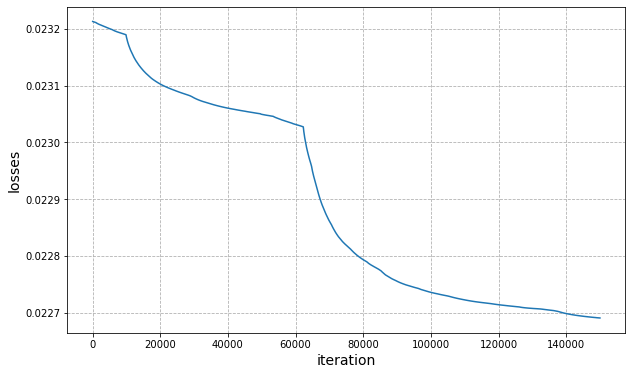

In [33]:
fig = plt.figure(figsize=(10,6))
plt.plot(losses)
plt.xlabel("iteration", fontsize=14)
plt.ylabel("losses", fontsize=14)
plt.grid(linestyle='--')
plt.show()

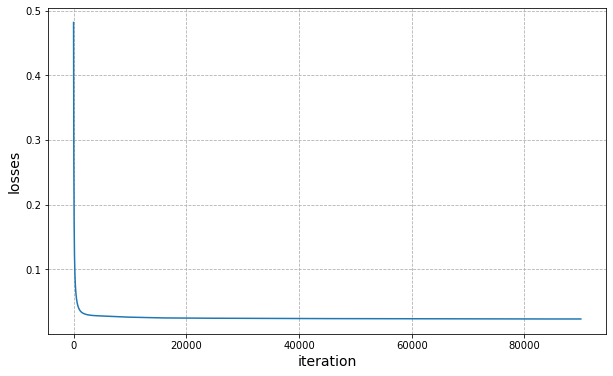

In [25]:
# Reference older plot
# fig = plt.figure(figsize=(10,6))
# plt.plot(losses)
# plt.xlabel("iteration", fontsize=14)
# plt.ylabel("losses", fontsize=14)
# plt.grid(linestyle='--')
# plt.show()

### Load saved model checkpoint

In [34]:
model_save_path = os.path.join(BASE_DIR, "trained_model_ckpts/checkpoint.pth.tar")
model_checkpoint = torch.load(f=model_save_path)
# model = models.get_architecture(model_checkpoint["arch"], args.dataset_name, device)
model.load_state_dict(model_checkpoint['state_dict'])

<All keys matched successfully>

In [67]:
from pesq import pesq
from pystoi import stoi

In [27]:
# test_dataloader = train_dataloader

In [65]:
num_batches = len(test_dataloader)
error = []
pseq = []

for itr in tqdm(range(num_batches)):
    clean_spec, noisy_spec = next(iter(test_dataloader))
    
    clean_spec = clean_spec[0].to(device)
    noisy_spec = noisy_spec[0].to(device)
#     print(clean_spec.shape, noisy_spec.shape)

    # compute the magnitude response of clean and noisy spectrograms
    clean_spec_mag = torch.abs(clean_spec).type(torch.float)
    noisy_spec_mag = torch.abs(noisy_spec).type(torch.float)
    noisy_spec_phase = noisy_spec / noisy_spec_mag

    model_out = model(noisy_spec_mag.unsqueeze(0).unsqueeze(0))

    # combine the model_out(magnitude) and phase to recover partially clean spectrogram
    clean_spec_pred = torch.multiply(model_out.squeeze(0).squeeze(0), noisy_spec_phase)
#     print(clean_spec_pred.shape, clean_spec_pred.dtype)
    
    clean_signal_gt = librosa.istft(clean_spec.cpu().detach().numpy(), win_length=512, hop_length=512)
    clean_signal_pred = librosa.istft(clean_spec_pred.cpu().detach().numpy(), win_length=512, hop_length=512)
#     print(clean_signal_gt.shape, clean_signal_pred.shape)

    error.append(np.linalg.norm(clean_signal_gt - clean_signal_pred))
    pseq.append(pesq(16000, clean_signal_pred, clean_signal_gt))
    test_sign_len.append(len(clean_signal_gt))

# error /= num_batches

  0%|          | 0/500 [00:00<?, ?it/s]

In [66]:
print("MSE - %f\nPSEQ - %f" %(sum(error)/len(error), sum(pseq)/len(error)))

MSE - 2869.110860
PSEQ - 1.029786


**Notes** \
1.I think we need to divide the mse for each gt, pred pair by the number of samples. It is basically cumalating the errors and given the signal is of length 61k, it shows up as a big number

In [69]:
stoi(clean_signal_pred, clean_signal_gt, 16000)

0.2512067285813216

In [120]:
noisy_signal = librosa.istft(noisy_spec.cpu().numpy(), win_length=512, hop_length=512)

In [125]:
inputSNR = 10*np.log10(np.average(clean_signal_gt**2)/np.average((noisy_signal-clean_signal_gt)**2))
outputSNR = 10*np.log10(np.average(clean_signal_pred**2)/np.average((noisy_signal-clean_signal_pred)**2))
print(inputSNR, outputSNR)

10.475200275097983 6.41639476932109e-05


In [126]:
clean_signal_pred

array([-0.00105849, -0.00644752,  0.00411855, ...,  0.00180336,
        0.00086581,  0.00050579])

In [127]:
clean_signal_gt

array([-0.00312179, -0.00355361, -0.00202245, ...,  0.01430902,
        0.01717009,  0.01164149])

In [133]:
importlib.reload(dataset)
from dataset import pickle_stft_data
signal_len_lst = pickle_stft_data('train', num_samples=1)

  0%|          | 0/1 [00:00<?, ?it/s]

0.21563622 -0.22483431
SNR -- 4.479288
